In [2]:
#imports
import pandas as pd 
import plotly as pl
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif, chi2

In [3]:
# TASK 1 : import dataset
DATA = pd.read_csv("mammographic_masses_data.csv")


In [4]:


# TASK 2 : Plotting data
#2.1 describing the data, these two functions allow a general sense of the type of data and provide a count for the benign and malignant cases
print(DATA.describe())
print(DATA['Severity'].value_counts())

# Display the margins where the severity is 1, using the loc function
severity_margins = DATA.loc[DATA['Severity'] == 1, 'Margin']
print(severity_margins)

# Select only ordinal/numerical features
numerical_features = ["BA", "Age", "Density", "Severity"]

# Calculate means and standard deviations for each feature
means = DATA[numerical_features].mean()
std_devs = DATA[numerical_features].std()

# Create bar chart for means
mean_fig = go.Figure()

mean_fig.add_trace(go.Bar(
    x=means.index,
    y=means.values,
    name='Mean',
    marker_color='blue',
    width=[0.4] * len(means)
))

mean_fig.update_layout(
    title="Mean of Numerical Features",
    xaxis_title="Features",
    yaxis_title="Mean",
    height=400,
    font=dict(
        size=18 
    ),
)

mean_fig.show()

# Create bar chart for standard deviations
std_fig = go.Figure()

std_fig.add_trace(go.Bar(
    x=std_devs.index,
    y=std_devs.values,
    name='Standard Deviation',
    marker_color='blue',
    width=[0.4] * len(means)
))

std_fig.update_layout(
    title="Standard Deviation of Numerical Features",
    xaxis_title="Features",
    yaxis_title="Standard Deviation",
    height=400,
    font=dict(
        size=18 
    ),
)

std_fig.show()


data_subset = DATA[numerical_features]

corr_matrix = data_subset.corr()

fig = px.imshow(corr_matrix, 
                labels=dict(x="Features", y="Features", color="Correlation"),
                x=corr_matrix.columns,
                y=corr_matrix.columns,
                color_continuous_scale='RdBu',
                zmin=-1, zmax=1, text_auto = True,
                title = "Correlation Heatmap of All Ordinal/Numerical Features")

fig.show()



# Use the .map function to create a severity column with appropriate names, which helps to make the box plot more understandable
DATA['Severity_Label'] = DATA['Severity'].map({0: 'Benign', 1: 'Malignant'})

#Create a box plot of the age vs the severity of the tumor
fig2 = px.box(DATA, x='Severity_Label', y='Age', color='Severity_Label',
             title="Box Plot of Age by Severity of Tumor (Benign vs Malignant)",
             labels={"Severity_Label": "Tumor Severity", "Age": "Patient Age"},
                color_discrete_map={'Benign': 'blue', 'Malignant': 'red'})
fig2.show()


# Create a box plot using age and BIRADS assessment
DATA['BA_Label'] = DATA['BA'].map({0: 'No Data', 1: 1, 2:2, 3:3, 4:4, 5:5, 6:6})
fig3 = px.box(DATA, x='BA_Label', y='Age',
                 title="Box Plot of Age vs BI-RADS",
                 labels={ "Age": "Patient Age", "BA_Label": "BI-RADS Assessment"})

fig3.show()

#Create a violin plot of the age vs the severity, to also show the frequency of different ages
fig4 = px.violin(DATA, y='Age', x='Severity_Label', 
                title="Violin Plot: Age Distribution for Benign vs Malignant Tumors",
                labels={"Severity_Label": "Tumor Type", "Age": "Patient Age"},
                color='Severity_Label', 
                color_discrete_map={'Benign': 'blue', 'Malignant': 'red'})

fig4.show()

               BA         Age       Shape      Margin     Density    Severity
count  959.000000  956.000000  930.000000  913.000000  885.000000  961.000000
mean     4.300313   55.487448    2.721505    2.796276    2.910734    0.463059
std      0.683469   14.480131    1.242792    1.566546    0.380444    0.498893
min      0.000000   18.000000    1.000000    1.000000    1.000000    0.000000
25%      4.000000   45.000000    2.000000    1.000000    3.000000    0.000000
50%      4.000000   57.000000    3.000000    3.000000    3.000000    0.000000
75%      5.000000   66.000000    4.000000    4.000000    3.000000    1.000000
max      6.000000   96.000000    4.000000    5.000000    4.000000    1.000000
Severity
0    516
1    445
Name: count, dtype: int64
0      5.0
1      1.0
2      5.0
4      5.0
8      5.0
      ... 
951    5.0
952    4.0
955    4.0
957    5.0
959    5.0
Name: Margin, Length: 445, dtype: float64


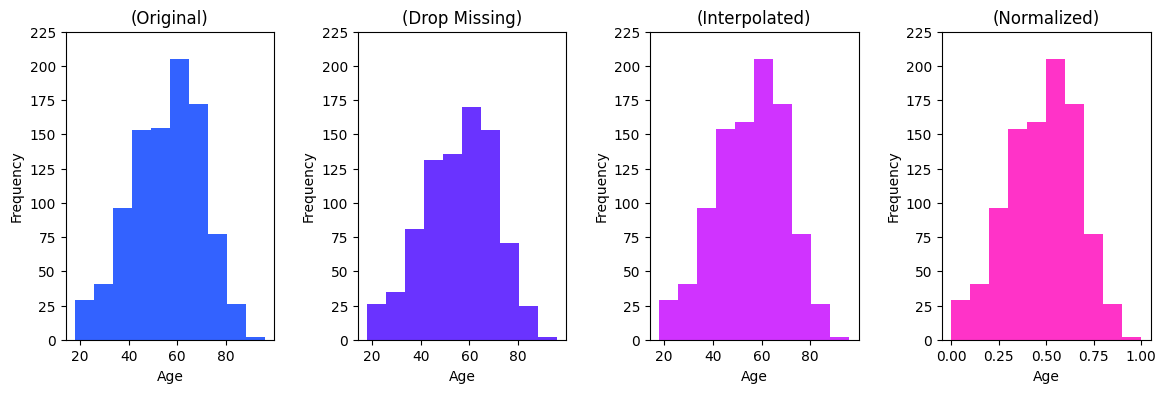

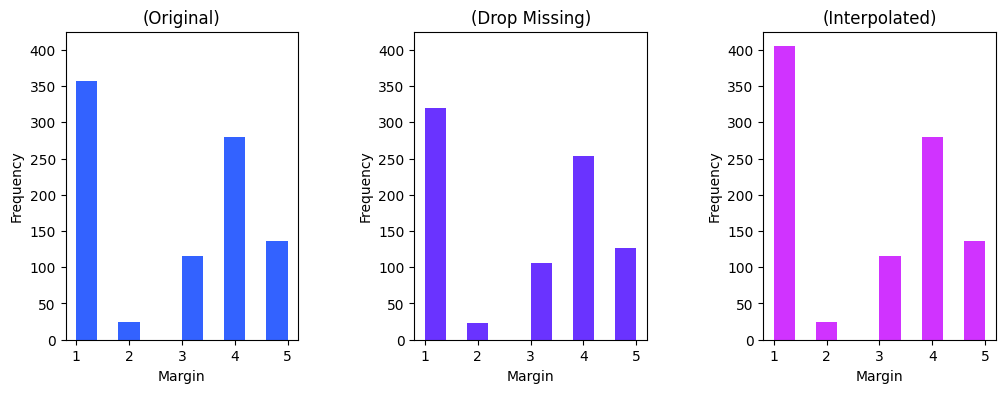

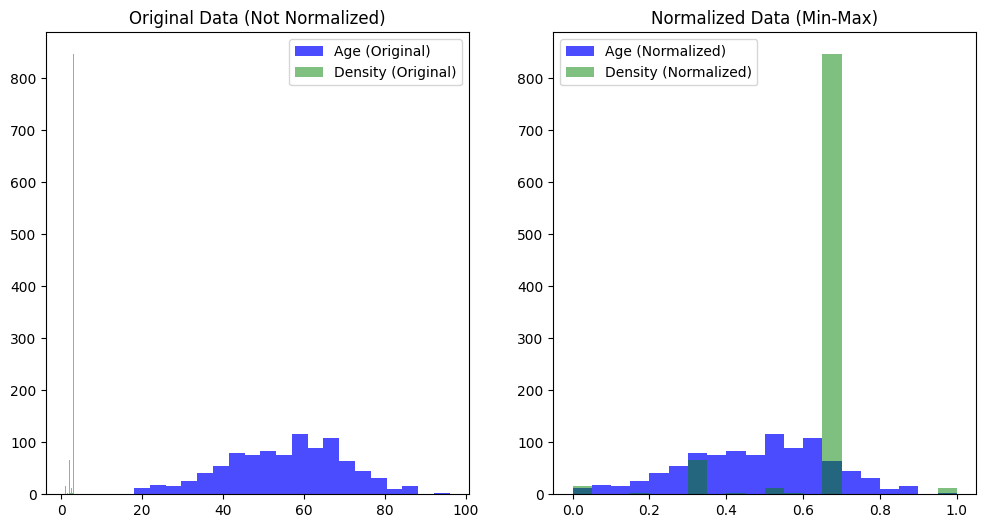

In [10]:
# TASK 3 : data preprocessing
interpolateDATA = DATA.copy()

# Drop BA column, since it is non-predictive
#interpolateDATA = interpolateDATA.drop(columns=['BA'])

# TASK 3.1

#Create two subplots. One to show the difference between different stages for an ordinal feature(Age) and one to show it for an ordinal one (Margin)
figage, plot = plt.subplots(1, 4, figsize=(14, 4),)
figmargin, plotmargin = plt.subplots(1, 3, figsize=(12, 4))

plot[0].hist(interpolateDATA["Age"], color = '#3362ff')
plot[0].set_title("(Original)")
plot[0].set_xlabel("Age")
plot[0].set_ylabel('Frequency')

plotmargin[0].hist(interpolateDATA["Margin"], color = '#3362ff')
plotmargin[0].set_title("(Original)")
plotmargin[0].set_xlabel("Margin")
plotmargin[0].set_ylabel('Frequency')

dropMissing = DATA.dropna()

plot[1].hist(dropMissing["Age"], color = '#6a33ff')
plot[1].set_title("(Drop Missing)")
plot[1].set_xlabel("Age")
plot[1].set_ylabel('Frequency')

plotmargin[1].hist(dropMissing["Margin"], color = '#6a33ff')
plotmargin[1].set_title("(Drop Missing)")
plotmargin[1].set_xlabel("Margin")
plotmargin[1].set_ylabel('Frequency')

#Seperate numerical/ordinal and nominal columns for filling in missing values
numerical_columns = ["Age", "Density"]  # Exclude BA as it is non-predictive, exclude Severity because it is the target feature
nominal_columns = ["Margin", "Shape"]  # Nominal features

# Filling missing nominal values using mode imputation, warning could result in bias 
for column in nominal_columns:
    interpolateDATA[column].fillna(interpolateDATA[column].mode()[0], inplace=True)
#Fill empty values using linear interpolation 
interpolateDATA[numerical_columns] = interpolateDATA[numerical_columns].interpolate(method='linear')

plot[2].hist(interpolateDATA["Age"], color = '#d033ff')
plot[2].set_title("(Interpolated)")
plot[2].set_xlabel("Age")
plot[2].set_ylabel('Frequency')

plotmargin[2].hist(interpolateDATA['Margin'], color = '#d033ff')
plotmargin[2].set_title("(Interpolated)")
plotmargin[2].set_xlabel("Margin")
plotmargin[2].set_ylabel('Frequency')

normalizeDATA = interpolateDATA.copy()
# TASK 3.2
# NORMALIZATION : min-max normalization on the Age column
normalizeDATA['Age'] = (normalizeDATA['Age'] - normalizeDATA['Age'].min()) / (normalizeDATA['Age'].max() - normalizeDATA['Age'].min()) 
# we will also use normalization on other ordinal parameters such as Density. We exclude BA again because it is non-predictive
do_normalize_ordinal = True
if do_normalize_ordinal: normalizeDATA['Density'] = (normalizeDATA['Density'] - normalizeDATA['Density'].min()) /(normalizeDATA['Density'].max() - normalizeDATA['Density'].min())

plot[3].hist(normalizeDATA["Age"], color ='#ff33c8')
plot[3].set_title("(Normalized)")
plot[3].set_xlabel("Age")
plot[3].set_ylabel('Frequency')

# Set the same y values for all graphs to visualize change in frequency
for ax in plot:
    ax.set_ylim(0,225)
for ax in plotmargin:
    ax.set_ylim(0,425)

#Adjust margins to make sure text doesn't overlap with another subplot
figage.subplots_adjust(wspace=0.4)
figmargin.subplots_adjust(wspace=0.5)

# Rendering comparison plots (before and after normalization)
fignormalization, plot = plt.subplots(1, 2, figsize=(12, 6))

# Plotting original (non-normalized) Age and Density
plot[0].hist(interpolateDATA["Age"], bins=20, color='blue', alpha=0.7, label='Age (Original)')
plot[0].hist(interpolateDATA["Density"], bins=20, color='green', alpha=0.5, label='Density (Original)')
plot[0].set_title('Original Data (Not Normalized)')
plot[0].legend()

# Plotting normalized Age and Density
plot[1].hist(normalizeDATA["Age"], bins=20, color='blue', alpha=0.7, label='Age (Normalized)')
plot[1].hist(normalizeDATA["Density"], bins=20, color='green', alpha=0.5, label='Density (Normalized)')
plot[1].set_title('Normalized Data (Min-Max)')
plot[1].legend()

plt.show()



Index(['Margin', 'Shape'], dtype='object')
Scores for each feature: [1.25685839e+01 2.89272319e+02 1.57042426e+02 1.73300406e-01
 2.87390341e+01]


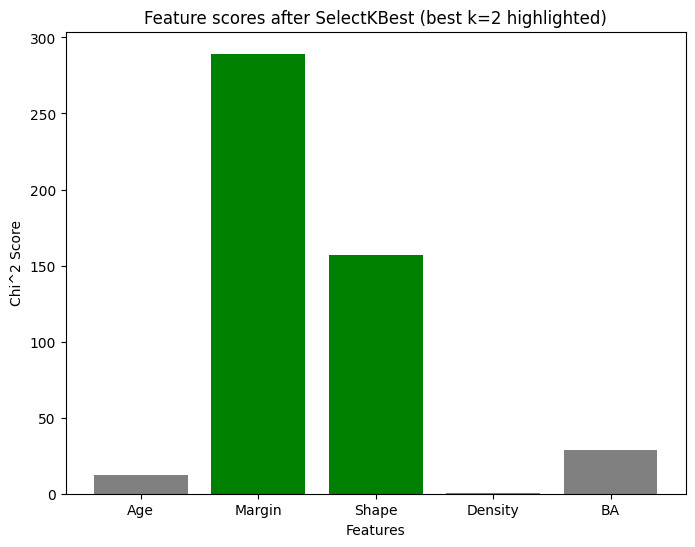

explained variance ratio: [0.79196038 0.11728811]


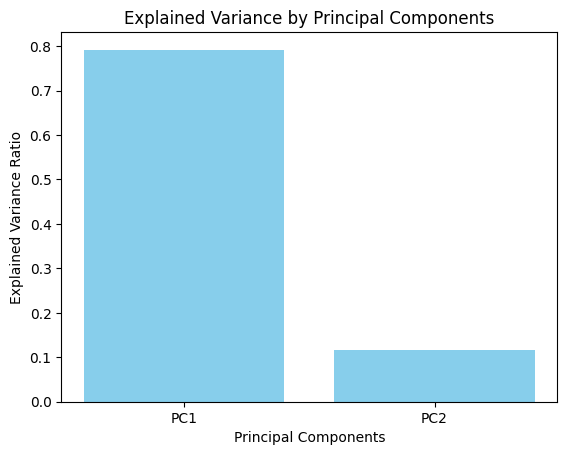

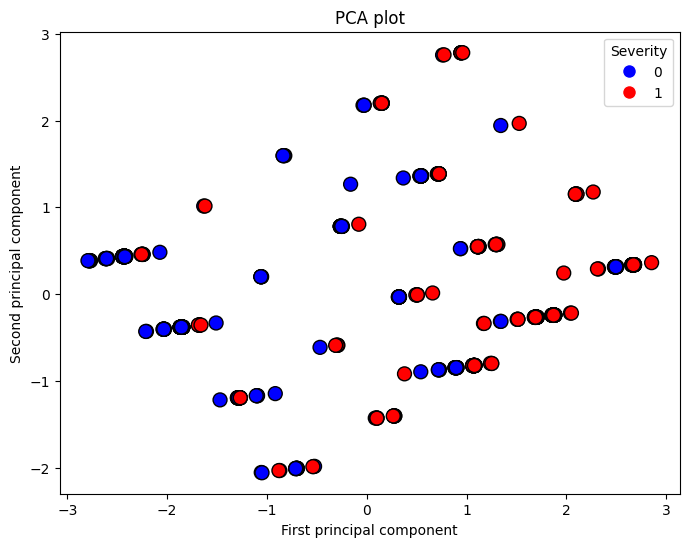

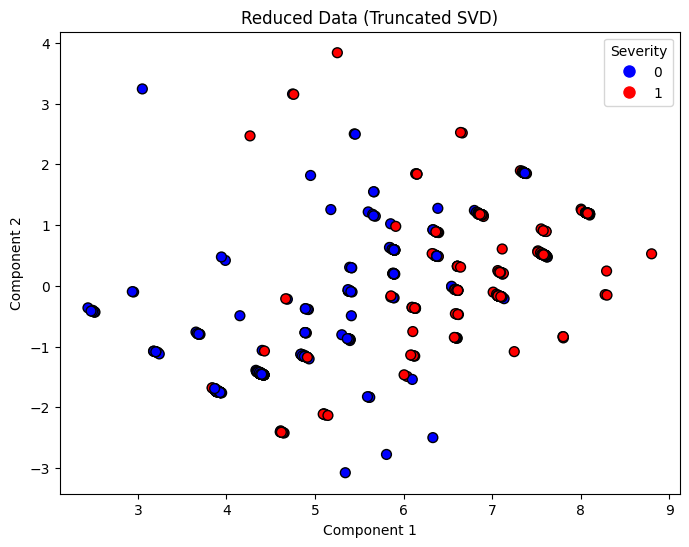

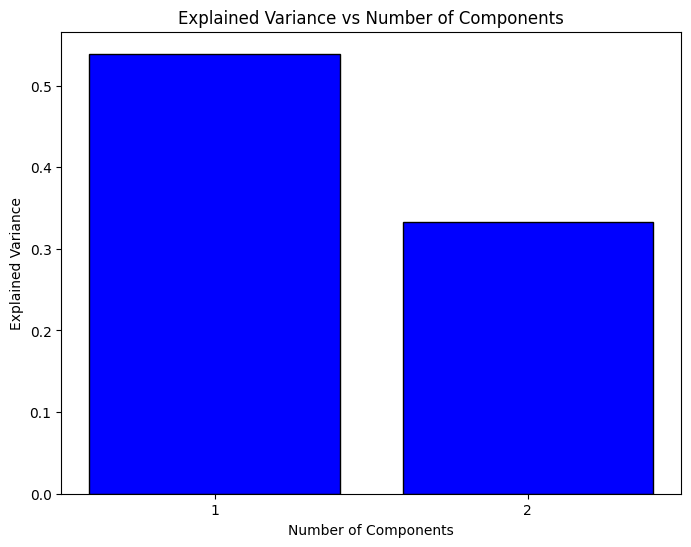

In [14]:
import numpy as np
# TASK 4 : data feature engineering (//nog niet klaar)

cData = normalizeDATA.dropna(subset=["BA"])
##########
#TASK 4.1#
##########
# AUTOMATIC FEATURE SELECTION : using univariate feature selection (for a classification problem)
#y = normalizeDATA["Severity"]
y = cData["Severity"]
features = ["Age", "Margin", "Shape", "Density", "BA"] # leaving out BA since it is described as being non-predictive
#x = normalizeDATA[features]
x = cData[features]

make_selection = SelectKBest(score_func=chi2, k=2)

selected_x = make_selection.fit_transform(x, y)
selected_feature_mask = x.columns[make_selection.get_support()]
scores = make_selection.scores_

print(selected_feature_mask)# What features got selected
print("Scores for each feature:", scores)


# After feature selectionm, highlighting k=2 best features
colors = ['green' if feature in selected_feature_mask else 'gray' for feature in features]
plt.figure(figsize=(8, 6))
plt.bar(features, scores, color=colors)
plt.title("Feature scores after SelectKBest (best k=2 highlighted)")
plt.ylabel("Chi^2 Score")
plt.xlabel("Features")
plt.show()


##########
#TASK 4.2#
##########
# PCA Dimensionality Reduction 
pca = sk.decomposition.PCA(n_components=2)
pca_x= pca.fit_transform(x)

print('explained variance ratio:', pca.explained_variance_ratio_)

explained_variance = pca.explained_variance_ratio_


# Plotting the explained variance
components = ['PC1', 'PC2']
plt.bar(components, explained_variance, color='skyblue')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(pca_x[:, 0], pca_x[:, 1], c=y, cmap='bwr', edgecolor='k', s=100)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('PCA plot')


# legend for the scatter plot
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='1')]
plt.legend(handles=handles, title="Severity")

plt.show()

##########
#TASK 4.3#
##########
# Truncated SVD

svd = sk.decomposition.TruncatedSVD(n_components=2)
x_svd = svd.fit_transform(x)


# Plot the reduced data (using Truncated SVD)
plt.figure(figsize=(8,6))
plt.scatter(x_svd[:, 0], x_svd[:, 1], c=y, cmap='bwr', edgecolor='k', s=50)
plt.title('Reduced Data (Truncated SVD)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

# Custom legend for the scatter plot
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='1')]
plt.legend(handles=handles, title="Severity")

plt.show()


explained_variance = svd.explained_variance_ratio_
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, color='b', edgecolor='k')
plt.title('Explained Variance vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.xticks([1, 2], ['1', '2'])

plt.show()
